Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import tqdm
import random

from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchvision.models import *

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

Check cuda availible

In [2]:
assert True == torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Calculate mean and std

In [3]:
# files = [file for file in os.listdir("trainval")]

# means = [0,0,0]
# stds = [0,0,0]

# for i in tqdm.tqdm(range(len(files))):
#     file = files[i]
#     img = torchvision.io.read_image(f"trainval/{file}").to(torch.float).to(device)
#     img = img / 256.0
#     for j in range(3):
#         means[j] += img[j].mean()
#         stds[j] += (img[j]**2).sum()

# for j in range(3):
#     means[j] /= (len(files))
#     stds[j] /= (40 * 40 * len(files))
#     stds[j] -= means[j]**2
#     stds[j] = torch.sqrt(stds[j])

#     # means[j] = int(means[j])
#     # stds[j] = int(stds[j])


# print(means)
# print(stds)

In [4]:
means = (0.5669, 0.5426, 0.4914)
stds = (0.2377, 0.2326, 0.2506)

class ImageDataset(Dataset):
    def __init__(self, X, Y, train = True):
        self.X = X
        self.Y = Y
        self.train = train

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, item):
        normalize = v2.Normalize(means, stds)
        augmentations = transforms.Compose([
            v2.RandomHorizontalFlip(),
            # v2.RandomAutocontrast(),
            # v2.RandomSolarize(0.4),
            transforms.RandomApply([v2.RandomAffine(degrees=0, translate=(1/8,1/8))], p=0.6),
            transforms.RandomApply([v2.RandomAffine(degrees=10)], p=0.6),
            # v2.RandomEqualize(0.5),
            # v2.RandomPosterize(16),
            # v2.RandomGrayscale(0.3),
            # v2.RandomPhotometricDistort(saturation=[1, 1.5], hue = [0,0], brightness=[0.875, 1.125], contrast=[0.9,1.1], p = 0.3),
            # v2.ColorJitter(saturation=[1, 1], hue = 0, brightness=[1, 1], contrast=[0.9,1.1])
        ])
        img = torchvision.io.read_image(f"trainval/{self.X[item]}").to(torch.float).to(device) / 256.0
        img = normalize(img)
        if self.train:
            img = augmentations(img)
        return img, self.Y[item]

data = pd.read_csv("labels.csv")
X_train, X_val, y_train, y_val = train_test_split(data["Id"], data["Category"], test_size=0.2, random_state=42, shuffle=True)

# X_train = X_train.reset_index()["Id"]
# y_train = y_train.reset_index()["Category"]
# X_val = X_val.reset_index()["Id"]
# y_val = y_val.reset_index()["Category"]

train_dataset = ImageDataset(X_train.to_list(), y_train.to_list())
val_dataset = ImageDataset(X_val.to_list(), y_val.to_list(), False)

In [5]:
train_loader = DataLoader(train_dataset, 32, True)
val_loader = DataLoader(val_dataset, 32, True)

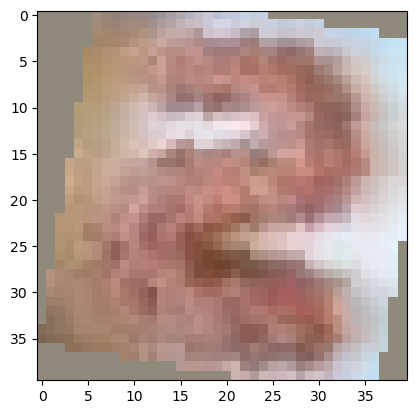

torch.Size([3, 40, 40])


In [6]:
def imshow(img):
    for i in range(3):
        img[i] = img[i] * stds[i] + means[i]
    npimg = img.to("cpu").numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    print(img.shape)

imshow(train_dataset[2][0])


In [7]:
@torch.no_grad()
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    criterion = F.cross_entropy
    
    for data, target in tqdm.tqdm(loader):

        data = data.to(device)  # images: batch_size x num_channels x height x width
        target = target.to(device)  # labels: batch_size

        logits = model(data)  # logits: batch_size x num_classes
        loss = criterion(logits, target)
    
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / len(target)

        acc_log.append(acc.item()) 
        
    return torch.tensor(loss_log).mean(), torch.tensor(acc_log).mean()

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = F.cross_entropy
    
    for data, target in tqdm.tqdm(train_loader):
        
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, target)  # use this loss for any training statistics
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / len(target)
        
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)
        if scheduler is not None:
            print(f"Epoch {epoch + 1} | lr={scheduler.get_last_lr()[0]}")
        else:
            print(f"Epoch {epoch + 1}")
        print(f" train loss: {torch.tensor(train_loss).mean()}, train acc: {torch.tensor(train_acc).mean()}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        torch.save(model, "model.pth")
        
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [8]:
net = efficientnet_v2_s(num_classes=200)

net.features[0][0].stride = (1, 1)
net.features[2][0].block[0][0].stride = (1, 1)
# net.features[3][0].block[0][0].stride = (1, 1)

net.classifier[0].p = 0.7

# print(net)

In [9]:
# model = efficientnet_v2_s(num_classes=200)
# rand_input = torch.randn(1,3,40,40)
# model(rand_input).shape

# torch.onnx.export(model, rand_input, "efficient_net.onnx")

# !netron efficient_net.onnx

In [10]:
net = net.to(device)

Training

In [11]:
torch.manual_seed(1984)
random.seed(1984)
np.random.seed(1984)
torch.cuda.manual_seed(1984)
# torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic = True

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4, nesterov=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 40)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 40, train_loader, val_loader, scheduler)

100%|██████████| 625/625 [00:24<00:00, 25.76it/s]


Epoch 1 | lr=0.01
 train loss: 5.1895060539245605, train acc: 0.014999999664723873
 val loss: 4.8496599197387695, val acc: 0.03525000065565109



100%|██████████| 625/625 [00:23<00:00, 26.08it/s]


Epoch 2 | lr=0.00998458666866564
 train loss: 4.788936614990234, train acc: 0.040037501603364944
 val loss: 4.565202236175537, val acc: 0.061400000005960464



100%|██████████| 625/625 [00:23<00:00, 26.07it/s]


Epoch 3 | lr=0.009938441702975689
 train loss: 4.575836658477783, train acc: 0.06319999694824219
 val loss: 4.305624008178711, val acc: 0.09440000355243683



100%|██████████| 625/625 [00:24<00:00, 25.38it/s]


Epoch 4 | lr=0.009861849601988383
 train loss: 4.350563049316406, train acc: 0.09171249717473984
 val loss: 4.0256452560424805, val acc: 0.133200004696846



100%|██████████| 625/625 [00:23<00:00, 26.18it/s]


Epoch 5 | lr=0.009755282581475769
 train loss: 4.093926429748535, train acc: 0.12240000069141388
 val loss: 3.763066291809082, val acc: 0.17309999465942383



100%|██████████| 625/625 [00:24<00:00, 25.87it/s]


Epoch 6 | lr=0.009619397662556435
 train loss: 3.8833932876586914, train acc: 0.15309999883174896
 val loss: 3.537569046020508, val acc: 0.21044999361038208



100%|██████████| 625/625 [00:24<00:00, 25.71it/s]


Epoch 7 | lr=0.00945503262094184
 train loss: 3.687640905380249, train acc: 0.18105000257492065
 val loss: 3.3522679805755615, val acc: 0.2446500062942505



100%|██████████| 625/625 [00:23<00:00, 26.26it/s]


Epoch 8 | lr=0.009263200821770462
 train loss: 3.5304312705993652, train acc: 0.20864999294281006
 val loss: 3.2200398445129395, val acc: 0.2644999921321869



100%|██████████| 625/625 [00:24<00:00, 25.67it/s]


Epoch 9 | lr=0.009045084971874739
 train loss: 3.389694929122925, train acc: 0.23160000145435333
 val loss: 3.082554578781128, val acc: 0.28929999470710754



100%|██████████| 625/625 [00:24<00:00, 25.40it/s]


Epoch 10 | lr=0.008802029828000156
 train loss: 3.273236036300659, train acc: 0.25306248664855957
 val loss: 2.9994025230407715, val acc: 0.3006500005722046



100%|██████████| 625/625 [00:23<00:00, 26.56it/s]


Epoch 11 | lr=0.008535533905932738
 train loss: 3.1584532260894775, train acc: 0.272662490606308
 val loss: 2.919175863265991, val acc: 0.3170500099658966



100%|██████████| 625/625 [00:24<00:00, 25.89it/s]


Epoch 12 | lr=0.00824724024165092
 train loss: 3.071706533432007, train acc: 0.29032498598098755
 val loss: 2.8420135974884033, val acc: 0.3310000002384186



100%|██████████| 625/625 [00:24<00:00, 25.81it/s]


Epoch 13 | lr=0.007938926261462366
 train loss: 2.9727022647857666, train acc: 0.30746251344680786
 val loss: 2.7758371829986572, val acc: 0.34665000438690186



100%|██████████| 625/625 [00:23<00:00, 26.09it/s]


Epoch 14 | lr=0.0076124928235797445
 train loss: 2.8859915733337402, train acc: 0.3233875036239624
 val loss: 2.731768846511841, val acc: 0.35455000400543213



100%|██████████| 625/625 [00:24<00:00, 25.41it/s]


Epoch 15 | lr=0.007269952498697735
 train loss: 2.8076868057250977, train acc: 0.33845001459121704
 val loss: 2.6848855018615723, val acc: 0.366349995136261



100%|██████████| 625/625 [00:24<00:00, 26.01it/s]


Epoch 16 | lr=0.0069134171618254504
 train loss: 2.730363607406616, train acc: 0.35253751277923584
 val loss: 2.647805690765381, val acc: 0.374099999666214



100%|██████████| 625/625 [00:24<00:00, 25.42it/s]


Epoch 17 | lr=0.006545084971874739
 train loss: 2.656562566757202, train acc: 0.36861249804496765
 val loss: 2.6049082279205322, val acc: 0.38440001010894775



100%|██████████| 625/625 [00:23<00:00, 26.24it/s]


Epoch 18 | lr=0.006167226819279529
 train loss: 2.5881893634796143, train acc: 0.379925012588501
 val loss: 2.5405964851379395, val acc: 0.39594998955726624



100%|██████████| 625/625 [00:23<00:00, 26.45it/s]


Epoch 19 | lr=0.005782172325201156
 train loss: 2.519958972930908, train acc: 0.39465001225471497
 val loss: 2.509012222290039, val acc: 0.40619999170303345



100%|██████████| 625/625 [00:24<00:00, 25.57it/s]


Epoch 20 | lr=0.005392295478639226
 train loss: 2.4531915187835693, train acc: 0.4065625071525574
 val loss: 2.4927165508270264, val acc: 0.4072999954223633



100%|██████████| 625/625 [00:23<00:00, 26.10it/s]


Epoch 21 | lr=0.005000000000000001
 train loss: 2.3860371112823486, train acc: 0.41997501254081726
 val loss: 2.4431874752044678, val acc: 0.4200499951839447



100%|██████████| 625/625 [00:23<00:00, 26.40it/s]


Epoch 22 | lr=0.004607704521360776
 train loss: 2.315155267715454, train acc: 0.4343250095844269
 val loss: 2.4391117095947266, val acc: 0.4235999882221222



100%|██████████| 625/625 [00:24<00:00, 25.79it/s]


Epoch 23 | lr=0.004217827674798847
 train loss: 2.251188278198242, train acc: 0.44728749990463257
 val loss: 2.4035303592681885, val acc: 0.4300999939441681



100%|██████████| 625/625 [00:24<00:00, 26.00it/s]


Epoch 24 | lr=0.0038327731807204736
 train loss: 2.179032325744629, train acc: 0.46127501130104065
 val loss: 2.3969128131866455, val acc: 0.4337500035762787



100%|██████████| 625/625 [00:24<00:00, 26.04it/s]


Epoch 25 | lr=0.003454915028125263
 train loss: 2.1069839000701904, train acc: 0.47523748874664307
 val loss: 2.377338171005249, val acc: 0.43904998898506165



100%|██████████| 625/625 [00:24<00:00, 25.52it/s]


Epoch 26 | lr=0.0030865828381745515
 train loss: 2.0399818420410156, train acc: 0.491225004196167
 val loss: 2.358992099761963, val acc: 0.4471000134944916



100%|██████████| 625/625 [00:23<00:00, 26.10it/s]


Epoch 27 | lr=0.0027300475013022664
 train loss: 1.9667189121246338, train acc: 0.5048875212669373
 val loss: 2.3505983352661133, val acc: 0.4462999999523163



100%|██████████| 625/625 [00:24<00:00, 25.59it/s]


Epoch 28 | lr=0.002387507176420256
 train loss: 1.9004019498825073, train acc: 0.5187125205993652
 val loss: 2.345545768737793, val acc: 0.45285001397132874



100%|██████████| 625/625 [00:23<00:00, 26.41it/s]


Epoch 29 | lr=0.002061073738537635
 train loss: 1.8172898292541504, train acc: 0.5362499952316284
 val loss: 2.3721282482147217, val acc: 0.4521999955177307



100%|██████████| 625/625 [00:23<00:00, 26.45it/s]


Epoch 30 | lr=0.0017527597583490825
 train loss: 1.7497665882110596, train acc: 0.5529749989509583
 val loss: 2.342554807662964, val acc: 0.4634999930858612



100%|██████████| 625/625 [00:24<00:00, 25.58it/s]


Epoch 31 | lr=0.0014644660940672629
 train loss: 1.6738603115081787, train acc: 0.5666750073432922
 val loss: 2.348160982131958, val acc: 0.46424999833106995



100%|██████████| 625/625 [00:23<00:00, 26.26it/s]


Epoch 32 | lr=0.0011979701719998454
 train loss: 1.5994454622268677, train acc: 0.5860249996185303
 val loss: 2.3580784797668457, val acc: 0.46369999647140503



100%|██████████| 625/625 [00:23<00:00, 26.48it/s]


Epoch 33 | lr=0.0009549150281252633
 train loss: 1.5254286527633667, train acc: 0.6002625226974487
 val loss: 2.362677574157715, val acc: 0.46560001373291016



100%|██████████| 625/625 [00:23<00:00, 26.31it/s]


Epoch 34 | lr=0.0007367991782295391
 train loss: 1.4505716562271118, train acc: 0.6201000213623047
 val loss: 2.3644137382507324, val acc: 0.47099998593330383



100%|██████████| 625/625 [00:24<00:00, 25.79it/s]


Epoch 35 | lr=0.0005449673790581611
 train loss: 1.3846584558486938, train acc: 0.6330875158309937
 val loss: 2.3729469776153564, val acc: 0.47209998965263367



100%|██████████| 625/625 [00:23<00:00, 26.17it/s]


Epoch 36 | lr=0.0003806023374435663
 train loss: 1.3380690813064575, train acc: 0.6471375226974487
 val loss: 2.3800456523895264, val acc: 0.4711500108242035



100%|██████████| 625/625 [00:23<00:00, 26.16it/s]


Epoch 37 | lr=0.00024471741852423234
 train loss: 1.2823232412338257, train acc: 0.658887505531311
 val loss: 2.389857769012451, val acc: 0.4726000130176544



100%|██████████| 625/625 [00:24<00:00, 25.48it/s]


Epoch 38 | lr=0.00013815039801161723
 train loss: 1.249428629875183, train acc: 0.6673874855041504
 val loss: 2.3841724395751953, val acc: 0.478300005197525



100%|██████████| 625/625 [00:24<00:00, 25.85it/s]


Epoch 39 | lr=6.155829702431172e-05
 train loss: 1.2243669033050537, train acc: 0.6750500202178955
 val loss: 2.3856446743011475, val acc: 0.4772000014781952



100%|██████████| 625/625 [00:24<00:00, 25.84it/s]


Epoch 40 | lr=1.5413331334360186e-05
 train loss: 1.2134307622909546, train acc: 0.6777125000953674
 val loss: 2.385225772857666, val acc: 0.47655001282691956



Plots

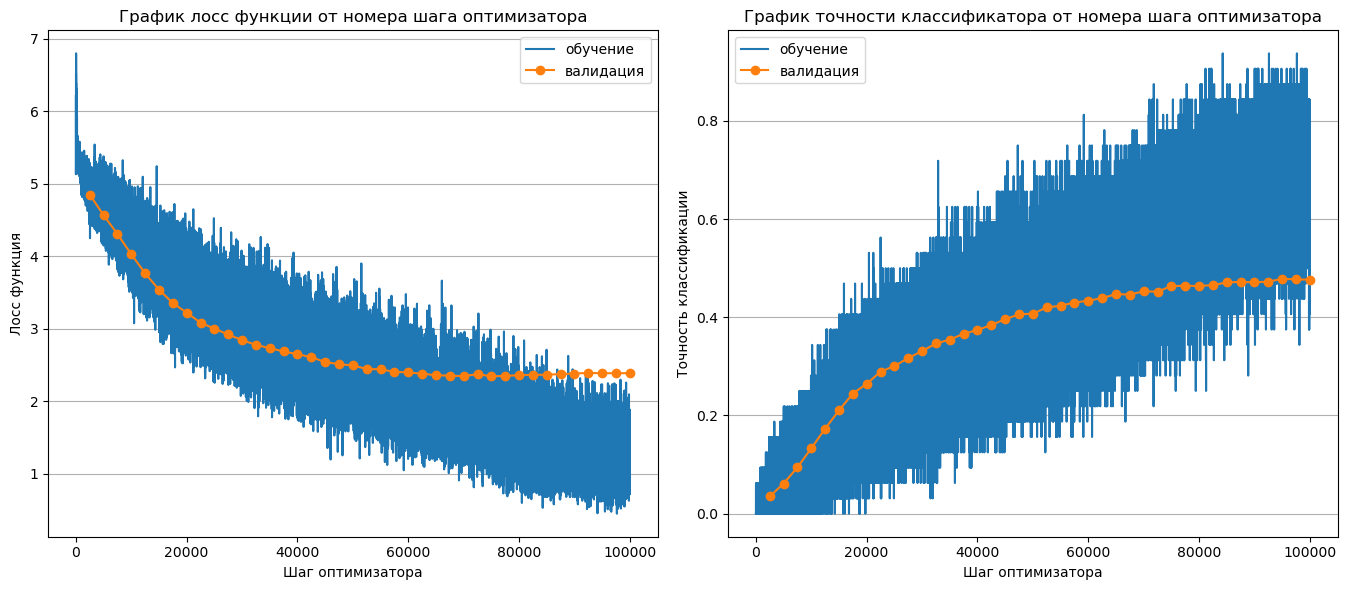

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))

ax[0].plot(train_loss_log, label = "обучение")
ax[0].plot((torch.arange(len(val_loss_log)) + 1) * len(train_loader), val_loss_log, label = "валидация", marker = "o")
ax[0].set_xlabel("Шаг оптимизатора")
ax[0].set_ylabel("Лосс функция")
ax[0].set_title("График лосс функции от номера шага оптимизатора")
ax[0].grid(axis = "y")
ax[0].legend()


ax[1].plot(train_acc_log, label = "обучение")
ax[1].plot((torch.arange(len(val_acc_log)) + 1) * len(train_loader), val_acc_log, label = "валидация", marker = "o")
ax[1].set_xlabel("Шаг оптимизатора")
ax[1].set_ylabel("Точность классификации")
ax[1].set_title("График точности классификатора от номера шага оптимизатора")
ax[1].grid(axis = "y")
ax[1].legend()

plt.tight_layout()
plt.show()

In [13]:
# net = torch.load("checkpoint.pth", weights_only=False)
# net = net.to(device)
# net.eval()

Test Time Augmentation

In [14]:
files = [file for file in os.listdir("test")]

pred = []

with torch.no_grad():
    for i in tqdm.tqdm(range(len(files))):
        file = files[i]
        normalize = v2.Normalize(means, stds)
        augmentations = transforms.Compose([
            v2.RandomHorizontalFlip(),
            transforms.RandomApply([v2.RandomAffine(degrees=0, translate=(1/8,1/8))], p=0.6),
            transforms.RandomApply([v2.RandomAffine(degrees=10)], p=0.6),
        ])
        img = torchvision.io.read_image(f"test/{file}").to(torch.float).to(device) / 256.0
        img = normalize(img)
        res = []
        for i in range(10):
            logits = net(augmentations(img).unsqueeze(0))[0]
            res.append(int(logits.argmax().to("cpu")))
        
        pred.append(max(res, key=lambda x: res.count(x)))


100%|██████████| 10000/10000 [41:11<00:00,  4.05it/s]


Simple testing

In [15]:
# files = [file for file in os.listdir("test")]

# pred = []

# with torch.no_grad():
#     for i in tqdm.tqdm(range(len(files))):
#         file = files[i]
#         transform = v2.Normalize((128, 128, 128), (128, 128, 128))
#         img = torchvision.io.read_image(f"test/{file}").to(torch.float).to(device)
#         img = transform(img)
#         logits = net(img.unsqueeze(0))[0]
#         pred.append(int(logits.argmax().to("cpu")))

In [16]:
data = {
    "Id" : files,
    "Category" : pred
}

df = pd.DataFrame(data)

In [17]:
df.to_csv("labels_test.csv", index=False)